# Main analysis for the "mapping culture" article.

Ted Underwood and Richard Jean So

This is an offshoot of a larger project, which is evolving slowly. We spun this off to make a subsidiary point. It branched from the main project back at [```../analysis/third_model_analysis1.ipynb.```](https://github.com/tedunderwood/asymmetry/blob/master/analysis/third_model_analysis1.ipynb)

We've edited this notebook so that it not only tests the hypotheses tested in the ```third_model``` notebook, but does so using two different metrics: KL divergence and cosine distance. 

For weird historical reasons, different passes at this project got described as "first supplement," "second supplement," and so on. (We kept adding a few more volumes to the model to test hypotheses more thoroughly.) The results we're using here are described as "fourth supplement," but the underlying metadata and topic model are the same as those used in the "third supplement." The fourth supplement is just a calculation run on the third supplement that keeps better track of cosine distance.

For the code used to measure the temporal asymmetries, see ```calculate_supp4_kld.py``` in this folder, and the worker script it calls, ```kld_calc_worker_supp4.py```

The analysis in this notebook begins after those Python scripts have run on the campus cluster (it's a compute-intensive process and we split it both across multiple nodes and across multiple cores in each node). 

The Python scripts produce a series of "summary files" that describe novelty, transience, and (what Barron et al call) "resonance" for each volume. In the article text, we are probably going to rename resonance something like "anticipation." We calculate this on cosine distance quite simply by subtracting the cosine distances measured from a given text *forward* ("transience") from the cosine distances measured *backward* ("novelty").

#### complexities of the data

We measured novelty and transience across temporal windows of different sizes (10, 25, and 40 years). We also experimented with a measurement that uses only the 5% or 20% of volumes closest to a given work when doing the calculation. These options make a slight difference, but in reporting results we emphasize an approach that uses a 25-year window, and all volumes in that window. That's the approach we originally preregistered. (Actually, we planned to use 10-, 20-, and 50-year windows, but slightly adjusted the plan when we realized a 50-year window would just produce a lot of NaNs).

#### imports

First, we import a few modules that will prove useful later.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, math, random
from scipy.stats import pearsonr, zscore, ttest_ind
from statistics import mean, stdev
from math import sqrt

### get metadata

In order to analyze the data we will need a metadata table that includes information about volumes, including inferred biographical information about the author (age, gender, nationality) and columns that assign volumes to particular "hypothesis" and "contrast" sets.

To trace how nationality prediction was done, see [```detect_americans```](https://github.com/tedunderwood/asymmetry/blob/master/analysis/detect_americans.ipynb).

In [2]:
meta = pd.read_csv('../supplement3/thirdmastermeta.tsv', sep = '\t', index_col = 'docid')
print(meta.shape)
meta.columns

(39784, 39)


Index(['allcopiesofwork', 'author', 'copiesin25yrs', 'earlyedition', 'imprint',
       'inferreddate', 'lastname', 'latestcomp', 'nationality', 'isusa',
       'actualgender', 'likelygender', 'title', 'authordate', 'birth', 'age',
       'recordid', 'best1821_1900', 'best1900_1950', 'best1950_1990',
       'anybest', 'best1821_1900contrast', 'best1900_1950contrast',
       'best1950_1990contrast', 'reviewed1850_1950',
       'reviewed1850_1950contrast', 'heath', 'heathcontrast', 'mostdiscussed',
       'mostdiscussedcontrast', 'usnorton', 'usnortoncontrast', 'nonusnorton',
       'nonusnortoncontrast', 'preregistered', 'preregisteredcontrast',
       'reviewed1965_1990', 'reviewed1965_1990contrast', 'toremove'],
      dtype='object')

### get data

Now the data itself. This is broken into a number of "summary files" because the processing that produced it had to be distributed across a cluster. (The entropy calculation is done by comparing individual volumes to each other, and when you've got 40k vols, the number of cross-comparisons becomes fairly large.)

So we first make a list of all the files we need. We'll do this twice, because the KLD data and cosine-similarity data are in separate files. First the KLD data.

In [4]:
paths = glob.glob('../supp4results/*0summary.tsv')
paths

['../supp4results/supp4_0summary.tsv',
 '../supp4results/supp4_8000summary.tsv',
 '../supp4results/supp4_10000summary.tsv',
 '../supp4results/supp4_14000summary.tsv',
 '../supp4results/supp4_30000summary.tsv',
 '../supp4results/supp4_34000summary.tsv',
 '../supp4results/supp4_6000summary.tsv',
 '../supp4results/supp4_2000summary.tsv',
 '../supp4results/supp4_24000summary.tsv',
 '../supp4results/supp4_20000summary.tsv',
 '../supp4results/supp4_4000summary.tsv',
 '../supp4results/supp4_36000summary.tsv',
 '../supp4results/supp4_18000summary.tsv',
 '../supp4results/supp4_32000summary.tsv',
 '../supp4results/supp4_22000summary.tsv',
 '../supp4results/supp4_26000summary.tsv',
 '../supp4results/supp4_28000summary.tsv',
 '../supp4results/supp4_38000summary.tsv',
 '../supp4results/supp4_16000summary.tsv',
 '../supp4results/supp4_12000summary.tsv']

... and then loop across the list, reading them in ... and finally concatenate the data frames.

In [5]:
dfs = []

for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    
klddata = pd.concat(dfs, verify_integrity = True)
print(klddata.shape)

(39784, 36)


#### Cosine data

Now we do the same thing for the cosine summary file.

In [7]:
paths = glob.glob('../supp4results/*cossummary.tsv')
paths

['../supp4results/supp4_24000cossummary.tsv',
 '../supp4results/supp4_30000cossummary.tsv',
 '../supp4results/supp4_8000cossummary.tsv',
 '../supp4results/supp4_34000cossummary.tsv',
 '../supp4results/supp4_0cossummary.tsv',
 '../supp4results/supp4_20000cossummary.tsv',
 '../supp4results/supp4_2000cossummary.tsv',
 '../supp4results/supp4_10000cossummary.tsv',
 '../supp4results/supp4_14000cossummary.tsv',
 '../supp4results/supp4_6000cossummary.tsv',
 '../supp4results/supp4_32000cossummary.tsv',
 '../supp4results/supp4_26000cossummary.tsv',
 '../supp4results/supp4_18000cossummary.tsv',
 '../supp4results/supp4_22000cossummary.tsv',
 '../supp4results/supp4_36000cossummary.tsv',
 '../supp4results/supp4_12000cossummary.tsv',
 '../supp4results/supp4_38000cossummary.tsv',
 '../supp4results/supp4_4000cossummary.tsv',
 '../supp4results/supp4_16000cossummary.tsv',
 '../supp4results/supp4_28000cossummary.tsv']

In [8]:
dfs = []

for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    
cosdata = pd.concat(dfs, verify_integrity = True)
print(cosdata.shape)

(39784, 36)


## Map a couple of columns from the metadata into our data

In order to normalize the data to correct for edge effects, we need the **latest-possible-date-of-composition** from metadata.

In [9]:
klddata = klddata.join(meta.latestcomp, how = 'inner')
cosdata = cosdata.join(meta.latestcomp, how = 'inner')

We're also going to normalize for nationality, because

    1. A lot of our hypotheses are US-specific, and
    2. resonance/anticipation tends to be slightly higher for US authors than for others, simply because the US fraction of the library **increases** across time.

Given those two facts, it gives us slightly more confidence to calculate resonance/anticipation separately for US and for non-US authors. We could in principle also separate authors who are British, Canadian, Indian, and so forth, but since we have few hypotheses specific to those nationalities, the gains are likely to be outweighed by increases in fragility.

Note that a lot of these nationalities are inferred / estimated. Overall accuracy (combining manual ground truth and estimation) comes to about 88-89%; consult [```detect_americans```](https://github.com/tedunderwood/asymmetry/blob/master/analysis/detect_americans.ipynb) for details.

We are also fully aware that people like Henry James move across the Atlantic halfway through their lives, that some volumes are collections combining authors of different nationalities, and so on. If we were to fully describe those nuances for each volume, a single "nationality" code would be grossly inadequate. It would also take a year or two of manual work, and as you'll see by the end of this notebook, wouldn't make much difference to our analysis.

Nationality is not a central subject of inquiry in this project. We're generating a simplified, imperfect *model* of nationality merely because it helps us (imperfectly) factor out a confounding variable that has a modest effect on our results. We think that provides a slight interpretive advantage, but the conclusions of our study would not be profoundly altered if we ignored nationality; to estimate the size of the effect, you can consult [earlier notebooks and models where nationality is not factored out,](https://github.com/tedunderwood/asymmetry/blob/master/analysis/first_eda.ipynb) or look at the end of this notebook where we test hypotheses using both normalized and non-normalized data.

In [10]:
klddata = klddata.join(meta.isusa, how = 'inner')
cosdata = cosdata.join(meta.isusa, how = 'inner')
klddata.shape

(39784, 38)

Essentially both ```klddata``` and ```cosdata``` have the same shape and the same columns. The only difference is that the values in one dataframe were produced by taking the KL divergence, and in the other, cosine similarity.

#### a look at the structure of the data

In [28]:
klddata.columns

Index(['novelty_1.0_10', 'novelty_1.0_25', 'novelty_1.0_40', 'novelty_0.2_10',
       'novelty_0.2_25', 'novelty_0.2_40', 'novelty_0.05_10',
       'novelty_0.05_25', 'novelty_0.05_40', 'novelty_0.025_10',
       'novelty_0.025_25', 'novelty_0.025_40', 'transience_1.0_10',
       'transience_1.0_25', 'transience_1.0_40', 'transience_0.2_10',
       'transience_0.2_25', 'transience_0.2_40', 'transience_0.05_10',
       'transience_0.05_25', 'transience_0.05_40', 'transience_0.025_10',
       'transience_0.025_25', 'transience_0.025_40', 'resonance_1.0_10',
       'resonance_1.0_25', 'resonance_1.0_40', 'resonance_0.2_10',
       'resonance_0.2_25', 'resonance_0.2_40', 'resonance_0.05_10',
       'resonance_0.05_25', 'resonance_0.05_40', 'resonance_0.025_10',
       'resonance_0.025_25', 'resonance_0.025_40', 'latestcomp', 'isusa'],
      dtype='object')

## Normalize data to reflect the edge effects caused by topic modeling

"Normalize" here means that we take a 7-year window of volumes that are by US authors (or non-US authors), and calculate z scores for volumes within that window. (I.e., subtract the mean and divide by standard deviation.) We replace the raw resonance/anticipation score for each volume with the z score calculated when it's at the center of the window.

I have already explained why we normalize for nationality. The reason for normalizing by date is that distance calculations on topic vectors cannot be trusted to remain uniform across a timeline. There are edge-sampling effects which make distances lower toward the ends of the timeline. This is true for both cosine distance and KLD.
Here's the loop where we actually do the normalizing. This does take some time to run (~20 min). There might be a simpler/quicker way to do this with an apply method, but it's a bit tricky, since we use a 7-year span to generate the z scores, but only copy over the scores for the central year.

The result are two new dataframes called ```zcosdata``` and ```zklddata.``` This is the data that will be used in most subsequent analyses.

In doing this, we also loop across columns and calculate a separate z score for each column. The reason is that resonance/anticipation can be calculated in a range of different ways--using different fractions of the dataset, and different temporal windows. There's a separate column for each of these possibilities. (Note, however, that we preregistered some guidelines about the modes of calculation we would actually use in checking hypotheses, to avoid a garden of infinitely forking paths.)

In [11]:
# normalize cosine-distance data

zcosdata = cosdata.copy(deep = True)
columns = [x for x in zcosdata.columns.tolist() if x.startswith('resonance')]

for col in columns:
    zcosdata[col] = np.nan
    # set default as empty

for yankeeness in [True, False]:
    for yr in range(1800, 2009):
        if yr % 50 == 1:
            print(yr)
        df = cosdata.loc[(cosdata.latestcomp >= yr - 3) & (cosdata.latestcomp <= yr + 3) & (cosdata.isusa == yankeeness), : ]
        for col in columns:
            nas = np.isnan(df[col])
            seriestonormalize = df.loc[~nas, col]
            nonnancount = np.count_nonzero(~np.isnan(seriestonormalize))
            indices = seriestonormalize.index.values
            
            if nonnancount > 0:
                zscores = zscore(seriestonormalize, nan_policy = 'omit')
            else:
                zscores = [np.nan] * len(indices)
                
            for idx, z in zip(indices, zscores):
                date = df.loc[idx, 'latestcomp']
                if date == yr:
                    zcosdata.loc[idx, col] = z

1801
1851
1901
1951
2001
1801
1851
1901
1951
2001


In [12]:
# normalize kld data

zklddata = cosdata.copy(deep = True)
columns = [x for x in zklddata.columns.tolist() if x.startswith('resonance')]

for col in columns:
    zklddata[col] = np.nan
    # set default as empty

for yankeeness in [True, False]:
    for yr in range(1800, 2009):
        if yr % 50 == 1:
            print(yr)
        df = klddata.loc[(cosdata.latestcomp >= yr - 3) & (klddata.latestcomp <= yr + 3) & (klddata.isusa == yankeeness), : ]
        for col in columns:
            nas = np.isnan(df[col])
            seriestonormalize = df.loc[~nas, col]
            nonnancount = np.count_nonzero(~np.isnan(seriestonormalize))
            indices = seriestonormalize.index.values
            
            if nonnancount > 0:
                zscores = zscore(seriestonormalize, nan_policy = 'omit')
            else:
                zscores = [np.nan] * len(indices)
                
            for idx, z in zip(indices, zscores):
                date = df.loc[idx, 'latestcomp']
                if date == yr:
                    zklddata.loc[idx, col] = z

1801
1851
1901
1951
2001
1801
1851
1901
1951
2001


## Test first hypothesis: frequently purchased volumes have more resonance/anticipation

The first hypothesis we test involves a correlation between two numeric variables: the anticipation (or resonance) score calculated for a volume and the number of copies of that volume attested in HathiTrust. The underlying theory here is that having a lot of copies in a library is a sign that a book was "ahead of its time," either in the causal sense that it sold a lot of copies and therefore had an *influence* on the future, or in the reverse-causal sense that it became (retrospectively) attractive to librarians because literary history happened to move in its direction. Our experiment doesn't currently allow us to distinguish those causal mechanisms.

To test this hypothesis we need a column from metadata that records the number of copies attested in Hathi libraries.

(To see where this is calculated, you'll need to consult the [```noveltmmeta```](https://github.com/tedunderwood/noveltmmeta) repo.)

In [13]:
zklddata = zklddata.join(meta.allcopiesofwork, how = 'inner')
zcosdata = zcosdata.join(meta.allcopiesofwork, how = 'inner')

### First test reprinting hypothesis for KLD data

Now we loop across the "resonance" columns to calculate correlation with number of attested volumes.

Since reprinting is sort of a feast-or-famine thing--and high numbers of attested volumes might increase out of proportion to the resonance score--we also try correlation with log(num_vols), which indeed is slightly stronger.

In [14]:
columns = [x for x in zklddata.columns.tolist() if x.startswith('resonance')]

for col in columns:
    nas = np.isnan(zklddata[col]) | np.isnan(zklddata['allcopiesofwork'])
    r, p = pearsonr(zklddata.loc[~nas, col], zklddata.loc[~nas, 'allcopiesofwork'])
    print(col, r, p)
    r, p = pearsonr(zklddata.loc[~nas, col], np.log(zklddata.loc[~nas, 'allcopiesofwork'] + 0.64))
    print("log-transformed: ", col, r, p)
    print()

resonance_1.0_10 0.08728919746648668 7.215488840012418e-63
log-transformed:  resonance_1.0_10 0.09530068959251048 1.2317250485910705e-74

resonance_1.0_25 0.08441329007260154 5.096101444975824e-52
log-transformed:  resonance_1.0_25 0.10088682829669138 1.2460851158212266e-73

resonance_1.0_40 0.07993584501409841 1.1528321568896112e-38
log-transformed:  resonance_1.0_40 0.0995640840050285 4.136257582308606e-59

resonance_0.2_10 0.10524455571512012 1.0688293288462121e-90
log-transformed:  resonance_0.2_10 0.1081091840319104 1.263064868489692e-95

resonance_0.2_25 0.0983437071210339 4.847838580061924e-70
log-transformed:  resonance_0.2_25 0.1074098904794799 2.8951403191967555e-83

resonance_0.2_40 0.0977114014609437 5.484801926139876e-57
log-transformed:  resonance_0.2_40 0.11067176080486792 1.1029149754733553e-72

resonance_0.05_10 0.11059881991222634 5.12197690748345e-100
log-transformed:  resonance_0.05_10 0.10966060871215587 2.3796698708407397e-98

resonance_0.05_25 0.11422297370338053

We calculated resonance for 100% of the corpus, as well as the 20%, 5% and 2.5% of volumes closest to the volume being evaluated.

We also measured across 10-, 25-, and 40-year windows.

**Notice, however, that the differences between different measurement strategies are on the whole rather modest!** There's a gap of a little more than .02 in the strength of correlation, and all of the tests sail way, way under *p* < .05. The differences between measurement strategies may be greater for individual vols, but when you're looking at broad correlations or differences of means between groups, the measurement strategy is rarely determinative.

### Now test reprinting hypothesis for cosines

In [15]:
for col in columns:
    nas = np.isnan(zcosdata[col]) | np.isnan(zcosdata['allcopiesofwork'])
    r, p = pearsonr(zcosdata.loc[~nas, col], zcosdata.loc[~nas, 'allcopiesofwork'])
    print(col, r, p)
    r, p = pearsonr(zcosdata.loc[~nas, col], np.log(zcosdata.loc[~nas, 'allcopiesofwork'] + 0.64))
    print("log-transformed: ", col, r, p)
    print()

resonance_1.0_10 0.06709482733592166 8.196622815642496e-38
log-transformed:  resonance_1.0_10 0.07470698893466719 1.7407655993823467e-46

resonance_1.0_25 0.07488757682412964 2.749824267044361e-41
log-transformed:  resonance_1.0_25 0.089599669113016 2.0970210199481114e-58

resonance_1.0_40 0.0750168203933484 3.034865989188687e-34
log-transformed:  resonance_1.0_40 0.09393725069466383 8.677462861708137e-53

resonance_0.2_10 0.08077950660533276 4.502056618201435e-54
log-transformed:  resonance_0.2_10 0.08920704244683847 1.3682594742099138e-65

resonance_0.2_25 0.08376437355976456 3.014651699434066e-51
log-transformed:  resonance_0.2_25 0.09885536284788415 9.348337907917226e-71

resonance_0.2_40 0.08377395306823843 2.615737487177438e-42
log-transformed:  resonance_0.2_40 0.100463025359223 3.734037311965372e-60

resonance_0.05_10 0.08510528969854922 7.680229943793652e-60
log-transformed:  resonance_0.05_10 0.09140352291298101 8.815119349382746e-69

resonance_0.05_25 0.09114073212058982 2.2

The correlations are about .02 lower, across the board. Again notice that **it doesn't make a huge difference whether you use cosine distance or KL divergence to test this.** KLD is definitely preferable, for reasons that are probably stated correctly in Barron et al. But the general strategy of subtracting forward-difference from backward-difference is the key innovation in that article. 

### Testing the first hypothesis without normalization

Notice also what makes a bigger difference than KLD/cos: normalizing the data to correct for edge effects in topic modeling.

In [16]:
klddata = klddata.join(meta.allcopiesofwork, how = 'inner')

for col in columns:
    nas = np.isnan(klddata[col]) | np.isnan(klddata['allcopiesofwork'])
    r, p = pearsonr(klddata.loc[~nas, col], klddata.loc[~nas, 'allcopiesofwork'])
    print(col, r, p)
    r, p = pearsonr(klddata.loc[~nas, col], np.log(klddata.loc[~nas, 'allcopiesofwork'] + 0.64))
    print("log-transformed: ", col, r, p)
    print()

resonance_1.0_10 0.04834811122565821 2.0968809631470307e-20
log-transformed:  resonance_1.0_10 0.023091191166847325 9.901629775302134e-06

resonance_1.0_25 0.025822315683363316 3.5712850347872804e-06
log-transformed:  resonance_1.0_25 0.013255779737391749 0.0173592420339194

resonance_1.0_40 0.025123494220364594 4.476993764925497e-05
log-transformed:  resonance_1.0_40 0.01760817637336868 0.004232893465470963

resonance_0.2_10 0.11355514935724816 2.2993226836268e-105
log-transformed:  resonance_0.2_10 0.08886380975132954 4.243474442567562e-65

resonance_0.2_25 0.05256783341877011 3.712185157866457e-21
log-transformed:  resonance_0.2_25 0.03304437832035578 2.9959505985579938e-09

resonance_0.2_40 0.03398270140009869 3.365013676219131e-08
log-transformed:  resonance_0.2_40 0.016127004620531918 0.00880252624247758

resonance_0.05_10 0.13224645111238742 1.5814306356708203e-142
log-transformed:  resonance_0.05_10 0.10910732690639938 2.253393648943615e-97

resonance_0.05_25 0.0828547586709998

That's a much weaker signal. It still confirms the hypothesis. But normalizing the data makes the correlation substantially stronger--usually more than doubling it. In particular it has a big effect on measurements that use a long temporal window and/or all the volumes. Those seem to be heavily distorted by nationality and/or edge effects.

## Other hypotheses

Most of the hypotheses that remain can be understood as binary comparisons between the means of two samples, and tested using a t-test. To make this systematic and reduce code repetition, we'll define a function that can be used to test a hypothesis about a given category--which we pass as an argument to the function.

In each case, we've developed a very cautious test, to avoid worries about confounding variables. For each hypothesis set of volumes we have randomly selected a contrast set (matched as closely as practical to the hypothesis set in genre, nationality, and date). The [matching strategy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/) is a way of addressing confounding variables without some of the slipperiness of a complex regression.

Then we run a t test on resonance for each of these categories. 

The test we are relying on as actually confirming the hypothesis is a pre-registered one: we measure resonance at the 25-year window, using all the volumes. This is the column ```resonance_1.0_25.``` (Actually, we pre-registered a plan to test 10, 20, and 50-year windows, whereas here we have 10, 25 and 40 year windows, but the difference between 20- and 25-year windows is not determinative at all.) For the sake of guiding future research, we also run a version of this test using only the 5% of volumes closest to the work in a given year.

In [17]:
def testahypothesis(hypothesis_cat, data, meta):
    contrast_cat = hypothesis_cat + 'contrast'
    
    hypodocs = meta.index[meta[hypothesis_cat] == 1].tolist()
    contradocs = meta.index[meta[contrast_cat] == 1].tolist()
    
    testoverlap = set(hypodocs).intersection(set(contradocs))
    print(len(testoverlap))
    
    columns = ['resonance_1.0_25', 'resonance_0.05_25']
    
    for col in columns:
        hypothesis_data = data.loc[hypodocs, col]
        hypothesis_data = hypothesis_data[~np.isnan(hypothesis_data)]
        
        contrast_data = data.loc[contradocs, col]
        contrast_data = contrast_data[~np.isnan(contrast_data)]
        
        t, p = ttest_ind(hypothesis_data, contrast_data)
        print(col, "t-test", t, p)
        a = hypothesis_data
        b = contrast_data
        cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
        print(col, "Cohen's d", cohens_d)
        print() 

### Testing hypothesis using KLD measurements

We have ten hypothesis categories to check: bestsellers in three chronological periods (these labels begin ```best```); volumes reviewed in elite venues 1850-1950, or the most-reviewed volumes 1965-1990; a list of the most-discussed author-title combinations in the JSTOR corpus; US authors anthologized in Heath; US authors anthologized in Norton or Norton Short Fiction; and non-US authors anthologized in the *Norton Anthology of English Literature.*

Finally, we preregistered a list of 20 books that we expected to be influential or ahead of their time.

In [18]:
cols2check = ['best1821_1900',
       'best1900_1950', 'best1950_1990', 'reviewed1850_1950', 'heath', 
        'mostdiscussed', 'usnorton', 'nonusnorton', 'preregistered',
       'reviewed1965_1990']

for col in cols2check:
    print(col)
    testahypothesis(col, zklddata, meta)
    print()

best1821_1900
1
resonance_1.0_25 t-test 4.728228445527444 3.65220964201985e-06
resonance_1.0_25 Cohen's d 0.5733819206752837

resonance_0.05_25 t-test 5.459700631524944 1.081163170769938e-07
resonance_0.05_25 Cohen's d 0.6620859525890821


best1900_1950
0
resonance_1.0_25 t-test 2.684897540560066 0.007687903350588126
resonance_1.0_25 Cohen's d 0.31976664371048014

resonance_0.05_25 t-test 2.1143308753730046 0.035370867857592074
resonance_0.05_25 Cohen's d 0.2518131427728281


best1950_1990
0
resonance_1.0_25 t-test -1.227309009512024 0.22091398442888913
resonance_1.0_25 Cohen's d -0.15807951902442088

resonance_0.05_25 t-test -1.8249982605659993 0.06924950717539169
resonance_0.05_25 Cohen's d -0.23497939371407023


reviewed1850_1950
0
resonance_1.0_25 t-test 8.112970035262245 1.2661947495462621e-15
resonance_1.0_25 Cohen's d 0.48171084616545207

resonance_0.05_25 t-test 8.71727776809012 9.874472549286122e-18
resonance_0.05_25 Cohen's d 0.5168601717583481


heath
0
resonance_1.0_25 t-te

#### analysis

There are a number of clearly significant confirmations: well-reviewed books both 1850-1950 and 1965-1990. Our preregistered 20 vols, also the non-US Norton vols. Bestsellers until 1950. (After 1950, interestingly, the effect of being bestseller is negative.)

Heath, usnorton, and mostdiscussed are not significant effects. For all of those groups, n is pretty small. On the other hand, nonusnorton and preregistered are significant with a sample size that is no larger, so the negative result here seems meaningful. Academic canonicity is a somewhat less reliable sign of precocity than being well-reviewed, or being a bestseller up to 1950.

The declining significance of bestsellerdom as time passes is pretty clear.

There's also one error in there: the "1" instead of a "0" in best1821_1900 suggests that we have a tiny overlap between the hypothesis and contrast set. That shouldn't happen. I will set about fixing.

### Testing binary hypotheses using cosine distances

Now let's see how much difference it makes if we use cosine distances instead of KL divergences.


In [19]:
cols2check = ['best1821_1900',
       'best1900_1950', 'best1950_1990', 'reviewed1850_1950', 'heath', 
        'mostdiscussed', 'usnorton', 'nonusnorton', 'preregistered',
       'reviewed1965_1990']

for col in cols2check:
    print(col)
    testahypothesis(col, zcosdata, meta)
    print()

best1821_1900
1
resonance_1.0_25 t-test 4.894647697375073 1.6963582661828981e-06
resonance_1.0_25 Cohen's d 0.5935632193077556

resonance_0.05_25 t-test 4.30857911999433 2.3033102530687738e-05
resonance_0.05_25 Cohen's d 0.5224919649431591


best1900_1950
0
resonance_1.0_25 t-test 2.3410346652946297 0.019932106074257244
resonance_1.0_25 Cohen's d 0.2788131712374385

resonance_0.05_25 t-test 1.763207019067235 0.07895631739793006
resonance_0.05_25 Cohen's d 0.20999490004236038


best1950_1990
0
resonance_1.0_25 t-test -1.7003277242367345 0.09037012587394383
resonance_1.0_25 Cohen's d -0.21897056652846222

resonance_0.05_25 t-test -1.1594983984105531 0.24741016661201073
resonance_0.05_25 Cohen's d -0.14928473228184286


reviewed1850_1950
0
resonance_1.0_25 t-test 8.66876871479035 1.4740017877087207e-17
resonance_1.0_25 Cohen's d 0.5143872498973918

resonance_0.05_25 t-test 8.442433945553981 9.3178953094924e-17
resonance_0.05_25 Cohen's d 0.5009677215425673


heath
0
resonance_1.0_25 t-tes

As far as I can see there is no major difference; the hypotheses confirmed with KLD are also confirmed with cosine distance.

### Testing hypotheses using non-normalized data

does this make a difference?

In [20]:
cols2check = ['best1821_1900',
       'best1900_1950', 'best1950_1990', 'reviewed1850_1950', 'heath', 
        'mostdiscussed', 'usnorton', 'nonusnorton', 'preregistered',
       'reviewed1965_1990']

for col in cols2check:
    print(col)
    testahypothesis(col, klddata, meta)
    print()

best1821_1900
1
resonance_1.0_25 t-test 4.182075022171092 3.9082615701701506e-05
resonance_1.0_25 Cohen's d 0.507151089725551

resonance_0.05_25 t-test 4.879865872551955 1.817428398324364e-06
resonance_0.05_25 Cohen's d 0.5917706597464294


best1900_1950
0
resonance_1.0_25 t-test 2.513992800166754 0.0124984220008915
resonance_1.0_25 Cohen's d 0.29941218533573694

resonance_0.05_25 t-test 1.9780242952747935 0.04890614473343739
resonance_0.05_25 Cohen's d 0.2355792653249139


best1950_1990
0
resonance_1.0_25 t-test -1.0548372414774256 0.2925649318850847
resonance_1.0_25 Cohen's d -0.1359274217851787

resonance_0.05_25 t-test -1.7965925209078857 0.07366302129819756
resonance_0.05_25 Cohen's d -0.2313211297690837


reviewed1850_1950
0
resonance_1.0_25 t-test 6.078234982082009 1.6538365084700576e-09
resonance_1.0_25 Cohen's d 0.3609528297449262

resonance_0.05_25 t-test 7.289421643756135 5.798815325875458e-13
resonance_0.05_25 Cohen's d 0.43162253237097886


heath
0
resonance_1.0_25 t-test 

I don't see cases where a hypothesis confirmed with normalized data is not confirmed with the raw data. But the effect sizes are generally weaker if we don't normalize.

## Specific preregistered volumes

When we consciously aimed at things we expected to be "like the future," our aim was true. Statistically significant even at n = 20, and effect sizes are huge.

Which volumes in particular create this effect? Note that these are z scores, so the mean for each column (in the whole collection is 0 and sd is 1).


In [23]:
prereg = meta.index[meta['preregistered'] == 1].tolist()
special = zklddata.loc[prereg, ['resonance_1.0_25', 'resonance_0.05_40', 'resonance_1.0_10', 'latestcomp']]
special = special.join(meta.author, how = 'inner')
special

,resonance_1.0_25,resonance_0.05_40,resonance_1.0_10,latestcomp,author
docid,,,,,
nyp.33433074943634,NaN,NaN,0.568580,1813,"Austen, Jane"
mdp.39015062084390,2.141427,1.469642,1.698105,1955,"Nabokov, Vladimir"
uc2.ark+=13960=t3cz3334b,1.497907,1.576004,0.735204,1884,"Twain, Mark"
uva.x000380956,-0.370519,0.211187,-0.377158,1865,"Verne, Jules"
nyp.33433076030760,0.283792,0.469276,0.192853,1844,"Poe, Edgar Allan"
inu.39000003707283,1.326140,1.500688,0.923641,1892,"Doyle, Arthur Conan"
uva.x000464259,0.077498,0.243171,0.276871,1850,"Hawthorne, Nathaniel"
mdp.39015000695182,1.899186,NaN,1.325339,1972,"Atwood, Margaret"
uc2.ark+=13960=t1hh6d619,1.094664,1.529024,0.689373,1900,"Dreiser, Theodore"


Vladimir Nabokov, Margaret Atwood, HG Wells, and Raymond Chandler are the champions of this round.

## Interaction with age

The author's age at time of composition / publication is a very powerful factor in this dataset. It's worth considering how it interacts with other categories.

Here we plot the author's age (at time of publication) on the x axis, the precocity of the work on y axis, and separate prominently reviewed authors (in blue) from randomly selected ones (in red).

In [27]:
# join age to the data 

zklddata = zklddata.join(meta.age, how = 'inner')

reviewed_docs = meta.index[meta.reviewed1850_1950 == 1].tolist()
unreviewed_docs = meta.index[meta.reviewed1850_1950contrast == 1].tolist()

reviewed_df = zklddata.loc[reviewed_docs, ['resonance_1.0_25', 'age']]
unreviewed_df = zklddata.loc[unreviewed_docs, ['resonance_1.0_25', 'age']]

plt.rcParams["figure.figsize"] = [10,8]

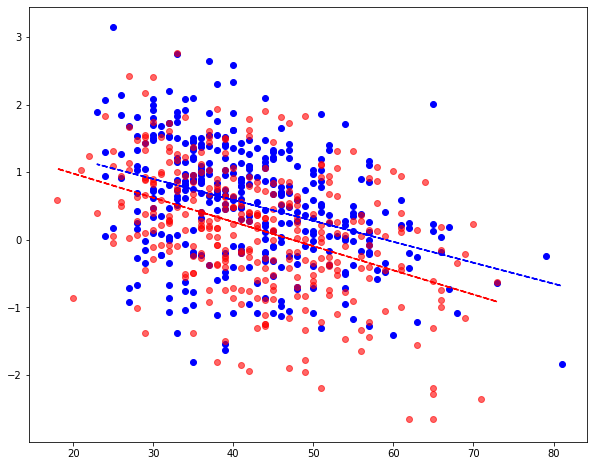

In [28]:
x = reviewed_df.age
y = reviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'b')
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = unreviewed_df.age
y = unreviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'r', alpha = 0.6)
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

Both factors matter. Reviewed authors have more precocity than unreviewed ones, at every age. But notice that any thirty-year-old author (even a randomly selected one) is likely to resemble the future more than any sixty-five-year-old one (even if famous).